# Analyse et Classification d'Images - Dataset Kaggle
## Notebook complet d'entraînement et comparaison de modèles

Par: Simon BOURLIER, Clément TRENS, Rémy LOURON et Killian PAVY

Ce notebook couvre :
- Exploration et visualisation du dataset
- Préparation des données (split train/test)
- Entraînement d'un modèle CNN personnalisé
- Fine-tuning d'un modèle pré-entraîné (ResNet18)
- Comparaison et analyse des résultats

## 1. Installation et Imports

In [46]:
!pip install kagglehub
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 13.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Utilisation de: cpu


## 2. Téléchargement du Dataset

In [49]:
path = kagglehub.dataset_download("mikhailma/test-dataset")
print(f"Dataset téléchargé dans: {path}")

100%|██████████| 393M/393M [00:02<00:00, 180MB/s]Extracting files...

Dataset téléchargé dans: /root/.cache/kagglehub/datasets/mikhailma/test-dataset/versions/1


## 3. Exploration de la Structure

In [52]:
def explore_directory(root_path):
    structure = {}
    root = Path(root_path)
    for item in root.rglob('*'):
        if item.is_file() and item.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
            relative = item.relative_to(root)
            parts = relative.parts
            if len(parts) > 2:
                category = parts[2]
                if category not in structure:
                    structure[category] = []
                structure[category].append(str(item))
    return structure

dataset_structure = explore_directory(path)
print("\n=== Structure du Dataset ===")
for category, images in dataset_structure.items():
    print(f"Catégorie '{category}': {len(images)} images")


=== Structure du Dataset ===
Catégorie 'Bicycle': 780 images
Catégorie 'Bridge': 533 images
Catégorie 'Bus': 1209 images
Catégorie 'Car': 3558 images
Catégorie 'Chimney': 124 images
Catégorie 'Crosswalk': 1240 images
Catégorie 'Hydrant': 952 images
Catégorie 'Motorcycle': 81 images
Catégorie 'Other': 1340 images
Catégorie 'Palm': 911 images
Catégorie 'Stair': 211 images
Catégorie 'Traffic Light': 791 images


## 4. Visualisation d'Échantillons

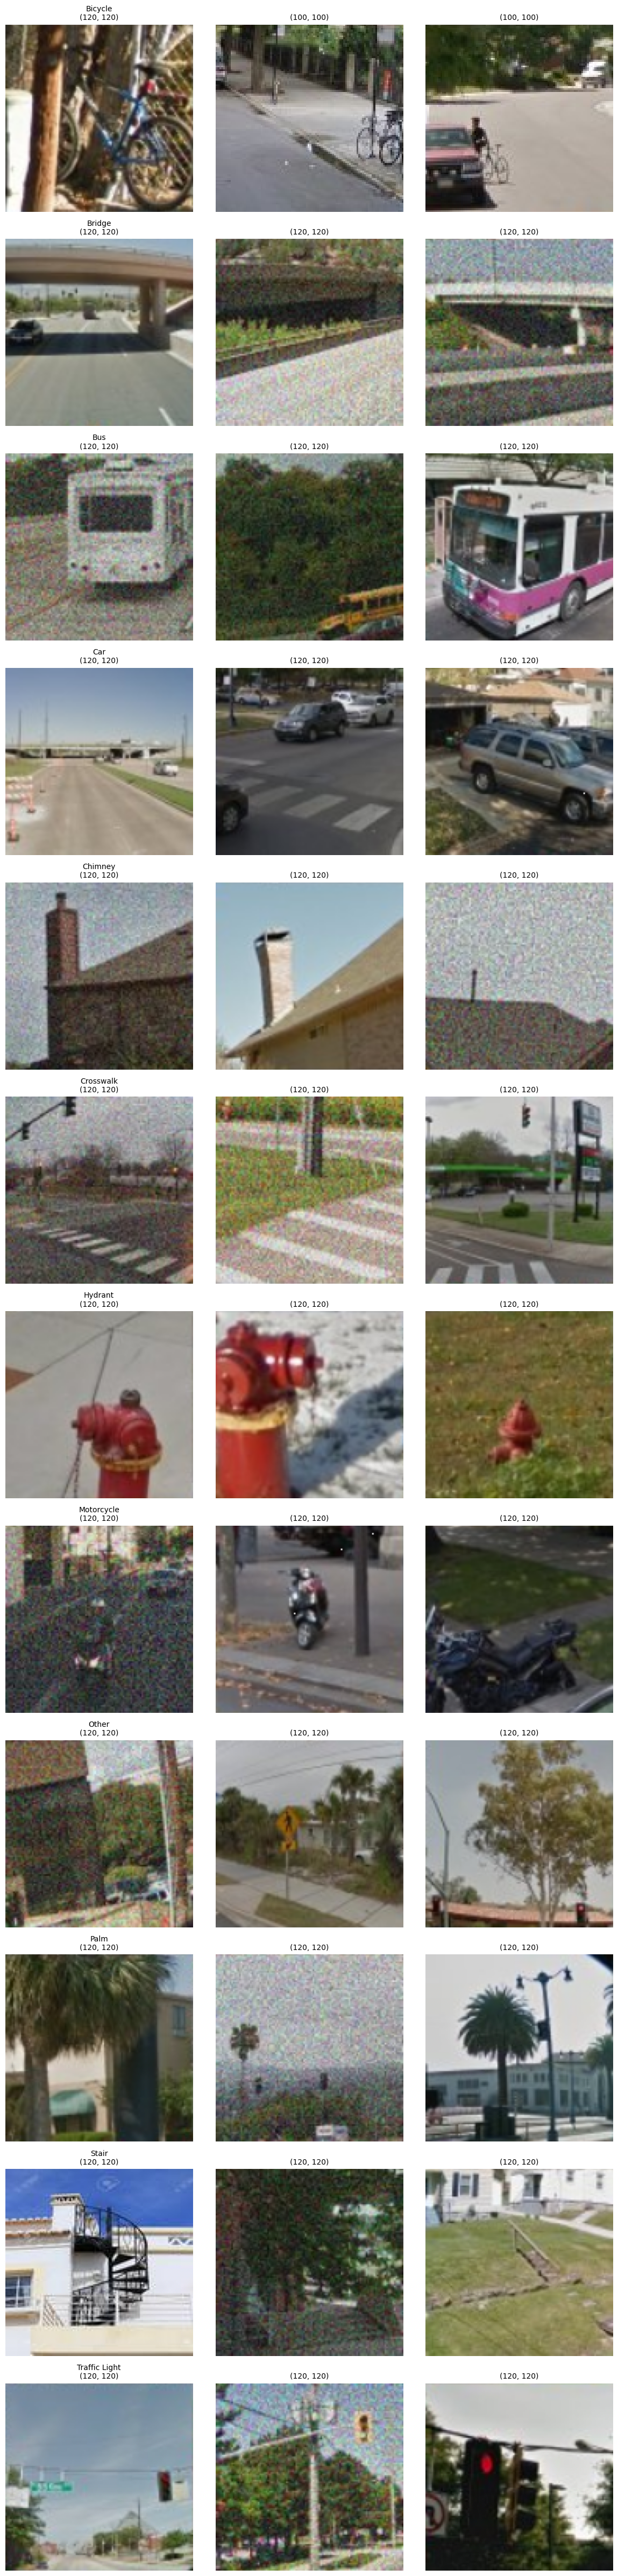

In [55]:
def show_sample_images(structure, n_samples=3):
    n_categories = len(structure)
    fig, axes = plt.subplots(n_categories, n_samples, figsize=(12, 4*n_categories))
    if n_categories == 1:
        axes = axes.reshape(1, -1)
    for idx, (category, images) in enumerate(structure.items()):
        samples = np.random.choice(images, min(n_samples, len(images)), replace=False)
        for j, img_path in enumerate(samples):
            img = Image.open(img_path)
            axes[idx, j].imshow(img)
            axes[idx, j].axis('off')
            title = f"{category}\n{img.size}" if j == 0 else f"{img.size}"
            axes[idx, j].set_title(title, fontsize=10)
    plt.tight_layout()
    plt.savefig('dataset_samples.png', dpi=100, bbox_inches='tight')
    plt.show()

show_sample_images(dataset_structure)

## 5. Création du Dataset PyTorch

In [56]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

all_images = []
all_labels = []
label_to_idx = {label: idx for idx, label in enumerate(dataset_structure.keys())}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

for category, images in dataset_structure.items():
    all_images.extend(images)
    all_labels.extend([label_to_idx[category]] * len(images))

print(f"Total: {len(all_images)} images, {len(label_to_idx)} classes")
print(f"Mapping: {label_to_idx}")

Total: 11730 images, 12 classes
Mapping: {'Bicycle': 0, 'Bridge': 1, 'Bus': 2, 'Car': 3, 'Chimney': 4, 'Crosswalk': 5, 'Hydrant': 6, 'Motorcycle': 7, 'Other': 8, 'Palm': 9, 'Stair': 10, 'Traffic Light': 11}


## 6. Split Train/Test et DataLoaders

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomImageDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Train: 9384, Test: 2346


## 7. Modèle CNN Personnalisé

In [74]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

custom_model = SimpleCNN(num_classes=len(label_to_idx)).to(device)
print(f"Paramètres: {sum(p.numel() for p in custom_model.parameters()):,}")

Paramètres: 25,786,700


## 8. Fonction d'Entraînement

In [65]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    history = {'loss': [], 'accuracy': []}
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': loss.item(), 'acc': 100*correct/total})
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        print(f'Epoch {epoch+1}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.2f}%')
    return history

## 9. Entraînement du CNN Personnalisé

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)
custom_history = train_model(custom_model, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10: 100%|██████████| 294/294 [14:00<00:00,  2.86s/it, loss=1.44, acc=37.1]
Epoch 1: Loss=1.8716, Acc=37.13%
Epoch 2/10: 100%|██████████| 294/294 [13:30<00:00,  2.76s/it, loss=1.42, acc=43.3]
Epoch 2: Loss=1.6411, Acc=43.33%
Epoch 3/10: 100%|██████████| 294/294 [14:01<00:00,  2.86s/it, loss=1.49, acc=46]
Epoch 3: Loss=1.5419, Acc=46.04%
Epoch 4/10: 100%|██████████| 294/294 [13:55<00:00,  2.84s/it, loss=2.19, acc=48.8]
Epoch 4: Loss=1.4616, Acc=48.80%
Epoch 5/10: 100%|██████████| 294/294 [14:06<00:00,  2.88s/it, loss=1.95, acc=51.5]
Epoch 5: Loss=1.3926, Acc=51.53%
Epoch 6/10: 100%|██████████| 294/294 [14:14<00:00,  2.91s/it, loss=0.918, acc=54.4]
Epoch 6: Loss=1.3089, Acc=54.36%
Epoch 7/10: 100%|██████████| 294/294 [14:09<00:00,  2.89s/it, loss=0.705, acc=56.2]
Epoch 7: Loss=1.2619, Acc=56.16%
Epoch 8/10: 100%|██████████| 294/294 [13:53<00:00,  2.84s/it, loss=1.2, acc=57.3]
Epoch 8: Loss=1.2241, Acc=57.33%
Epoch 9/10: 100%|██████████| 294/294 [14:49<00:00,  3.03s/it, loss=0.665,

## 10. Modèle Pré-entraîné ResNet18

In [80]:
pretrained_model = models.resnet18(pretrained=True)
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, len(label_to_idx))
pretrained_model = pretrained_model.to(device)

optimizer_pretrained = optim.Adam(pretrained_model.parameters(), lr=0.0001)
pretrained_history = train_model(pretrained_model, train_loader, criterion, optimizer_pretrained, epochs=5)

Epoch 1/5: 100%|██████████| 294/294 [27:39<00:00,  5.65s/it, loss=0.134, acc=75.8]
Epoch 1: Loss=0.7600, Acc=75.82%
Epoch 2/5: 100%|██████████| 294/294 [27:02<00:00,  5.52s/it, loss=0.104, acc=86.1]
Epoch 2: Loss=0.4086, Acc=86.08%
Epoch 3/5: 100%|██████████| 294/294 [22:25<00:00,  4.58s/it, loss=0.204, acc=89.6]
Epoch 3: Loss=0.3164, Acc=89.61%
Epoch 4/5: 100%|██████████| 294/294 [23:58<00:00,  4.89s/it, loss=0.0505, acc=91.6]
Epoch 4: Loss=0.2446, Acc=91.57%
Epoch 5/5: 100%|██████████| 294/294 [20:46<00:00,  4.24s/it, loss=0.044, acc=93.5]Epoch 5: Loss=0.1936, Acc=93.54%



## 11. Évaluation des Modèles

In [11]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Évaluation'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return all_labels, all_preds, accuracy

custom_labels, custom_preds, custom_acc = evaluate_model(custom_model, test_loader)
print(f"CNN Personnalisé: {custom_acc*100:.2f}%")

pretrained_labels, pretrained_preds, pretrained_acc = evaluate_model(pretrained_model, test_loader)
print(f"ResNet18: {pretrained_acc*100:.2f}%")

Évaluation: 100%|██████████| 74/74 [00:10<00:00,  7.08it/s]


CNN Personnalisé: 62.83%


Évaluation: 100%|██████████| 74/74 [00:07<00:00, 10.11it/s]

ResNet18: 85.85%


## 12. Courbes d'Apprentissage

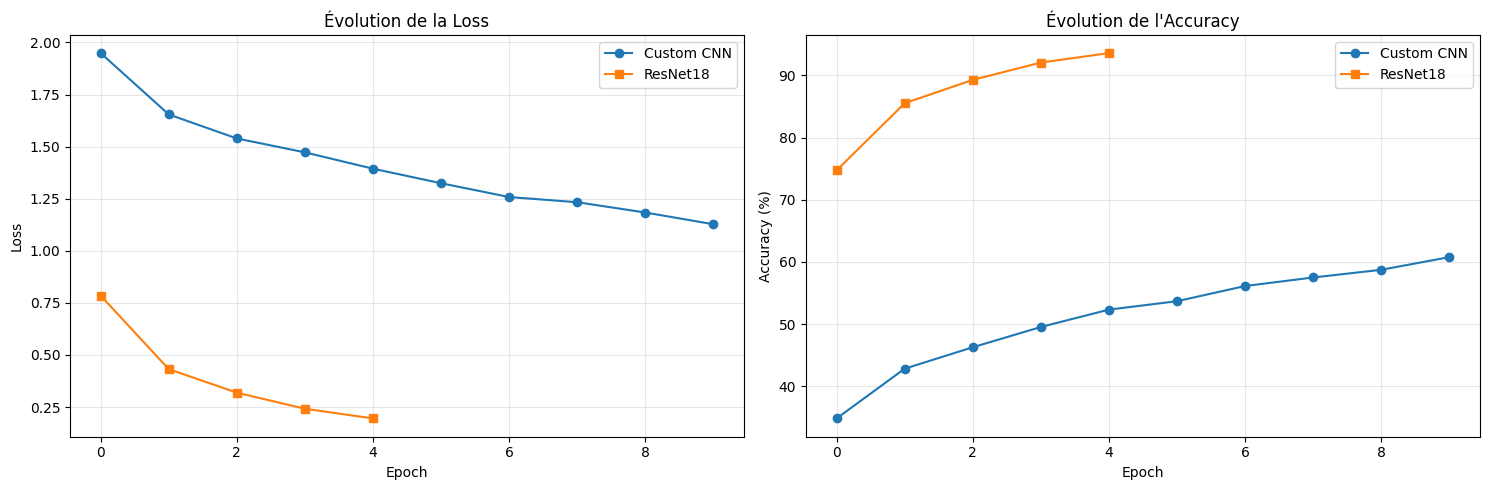

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(custom_history['loss'], label='Custom CNN', marker='o')
axes[0].plot(pretrained_history['loss'], label='ResNet18', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Évolution de la Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(custom_history['accuracy'], label='Custom CNN', marker='o')
axes[1].plot(pretrained_history['accuracy'], label='ResNet18', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title("Évolution de l'Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=100)
plt.show()

## 13. Matrices de Confusion

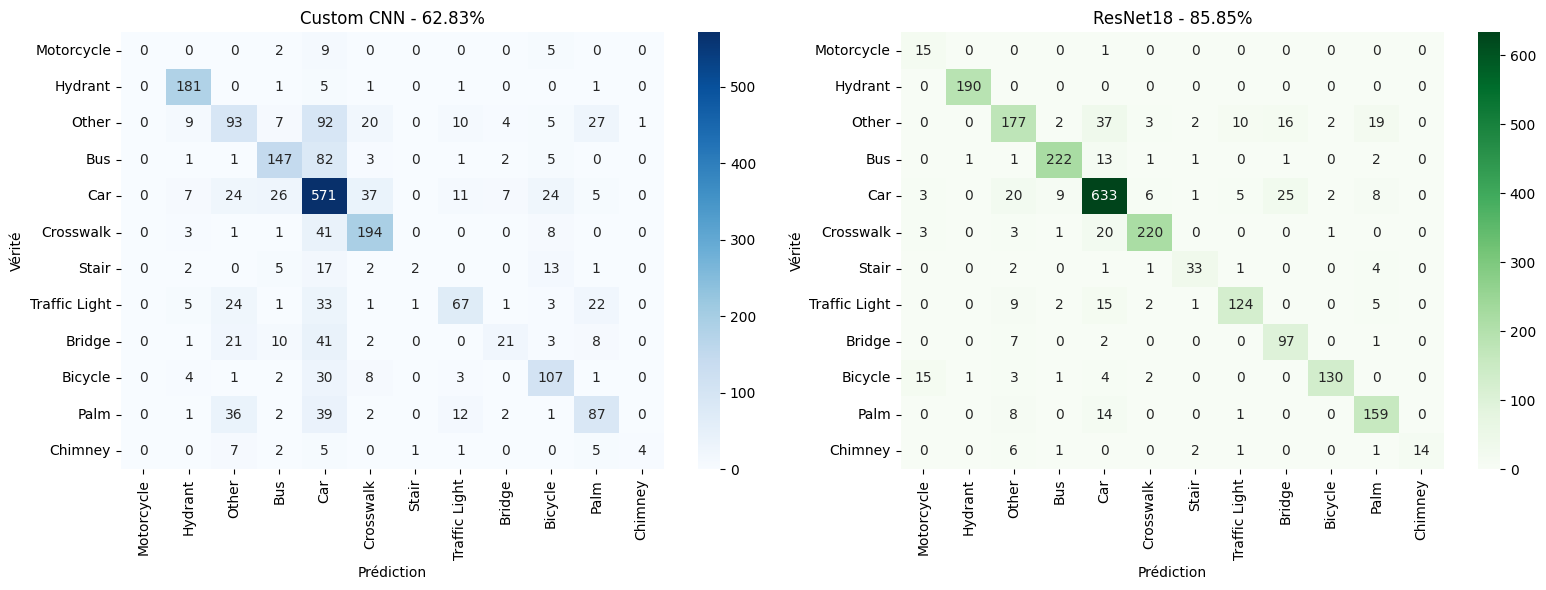

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_custom = confusion_matrix(custom_labels, custom_preds)
cm_pretrained = confusion_matrix(pretrained_labels, pretrained_preds)

sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=idx_to_label.values(), yticklabels=idx_to_label.values())
axes[0].set_title(f'Custom CNN - {custom_acc*100:.2f}%')
axes[0].set_ylabel('Vérité')
axes[0].set_xlabel('Prédiction')

sns.heatmap(cm_pretrained, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=idx_to_label.values(), yticklabels=idx_to_label.values())
axes[1].set_title(f'ResNet18 - {pretrained_acc*100:.2f}%')
axes[1].set_ylabel('Vérité')
axes[1].set_xlabel('Prédiction')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=100)
plt.show()

## 14. Rapports de Classification

In [14]:
print("=== Custom CNN ===")
print(classification_report(custom_labels, custom_preds, target_names=idx_to_label.values()))

print("\n=== ResNet18 ===")
print(classification_report(pretrained_labels, pretrained_preds, target_names=idx_to_label.values()))

=== Custom CNN ===
               precision    recall  f1-score   support

   Motorcycle       0.00      0.00      0.00        16
      Hydrant       0.85      0.95      0.90       190
        Other       0.45      0.35      0.39       268
          Bus       0.71      0.61      0.66       242
          Car       0.59      0.80      0.68       712
    Crosswalk       0.72      0.78      0.75       248
        Stair       0.50      0.05      0.09        42
Traffic Light       0.63      0.42      0.51       158
       Bridge       0.57      0.20      0.29       107
      Bicycle       0.61      0.69      0.65       156
         Palm       0.55      0.48      0.51       182
      Chimney       0.80      0.16      0.27        25

     accuracy                           0.63      2346
    macro avg       0.58      0.46      0.47      2346
 weighted avg       0.62      0.63      0.61      2346


=== ResNet18 ===
               precision    recall  f1-score   support

   Motorcycle       0.42

## 15. Conclusion

In [15]:
comparison = pd.DataFrame({
    'Modèle': ['Custom CNN', 'ResNet18'],
    'Accuracy (%)': [custom_acc*100, pretrained_acc*100],
    'Epochs': [10, 5],
    'Paramètres': [
        sum(p.numel() for p in custom_model.parameters()),
        sum(p.numel() for p in pretrained_model.parameters())
    ]
})

print("\n" + "="*70)
print("COMPARAISON FINALE")
print("="*70)
print(comparison.to_string(index=False))

print(f"\n✓ Gain transfer learning: {(pretrained_acc-custom_acc)*100:+.2f} points")
print(f"✓ ResNet18 converge 2x plus vite (5 vs 10 epochs)")
print(f"✓ Le transfer learning est plus efficace sur datasets limités")


COMPARAISON FINALE
    Modèle  Accuracy (%)  Epochs  Paramètres
Custom CNN     62.830350      10    25786700
  ResNet18     85.848252       5    11182668

✓ Gain transfer learning: +23.02 points
✓ ResNet18 converge 2x plus vite (5 vs 10 epochs)
✓ Le transfer learning est plus efficace sur datasets limités


## Testing both models

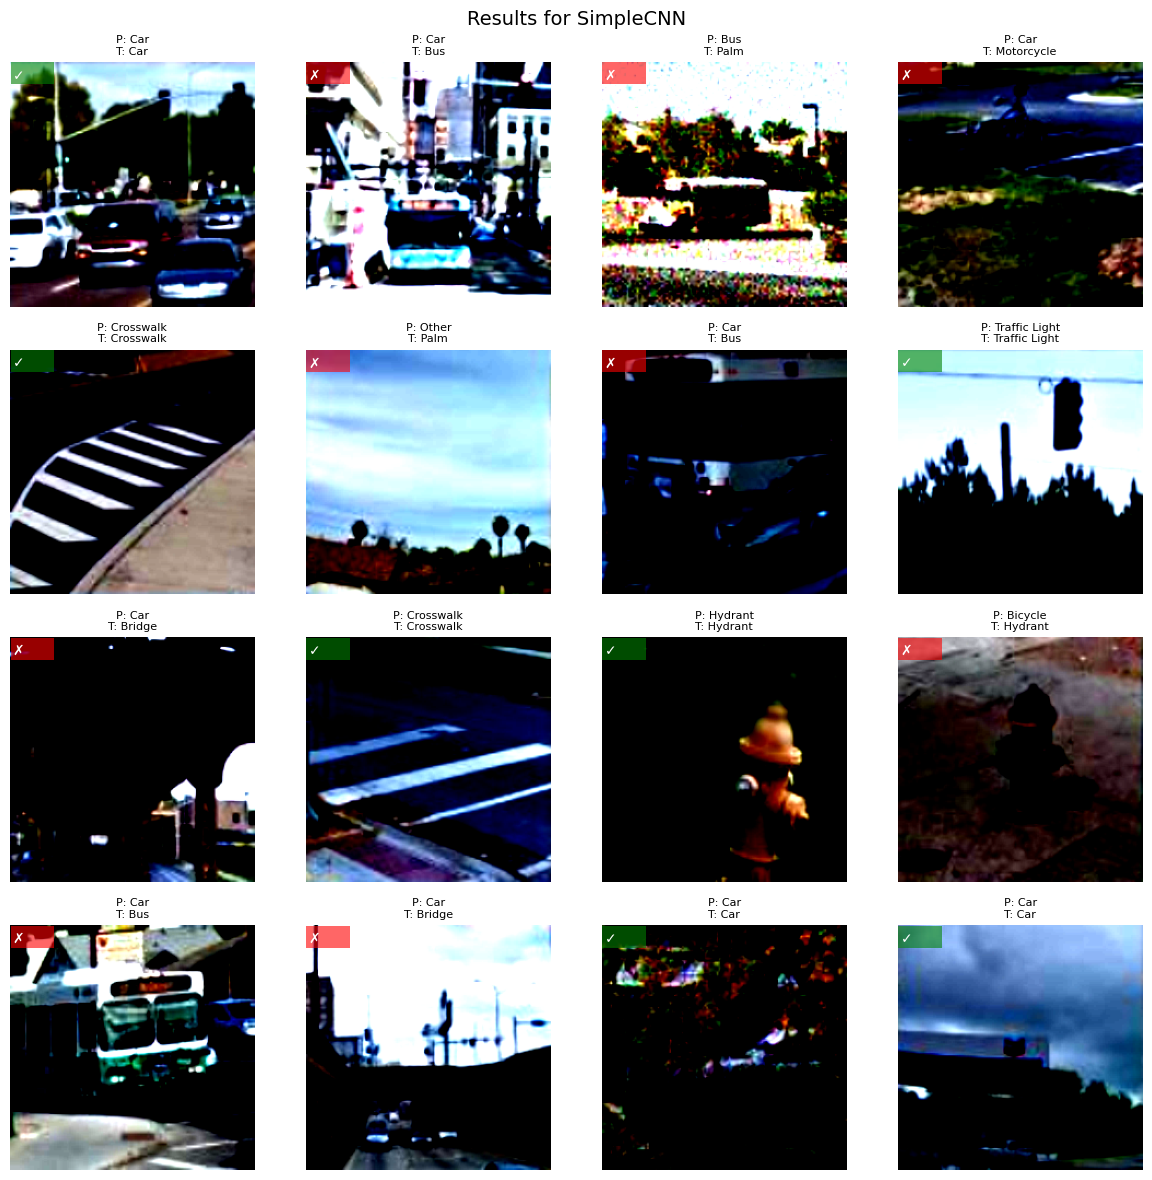

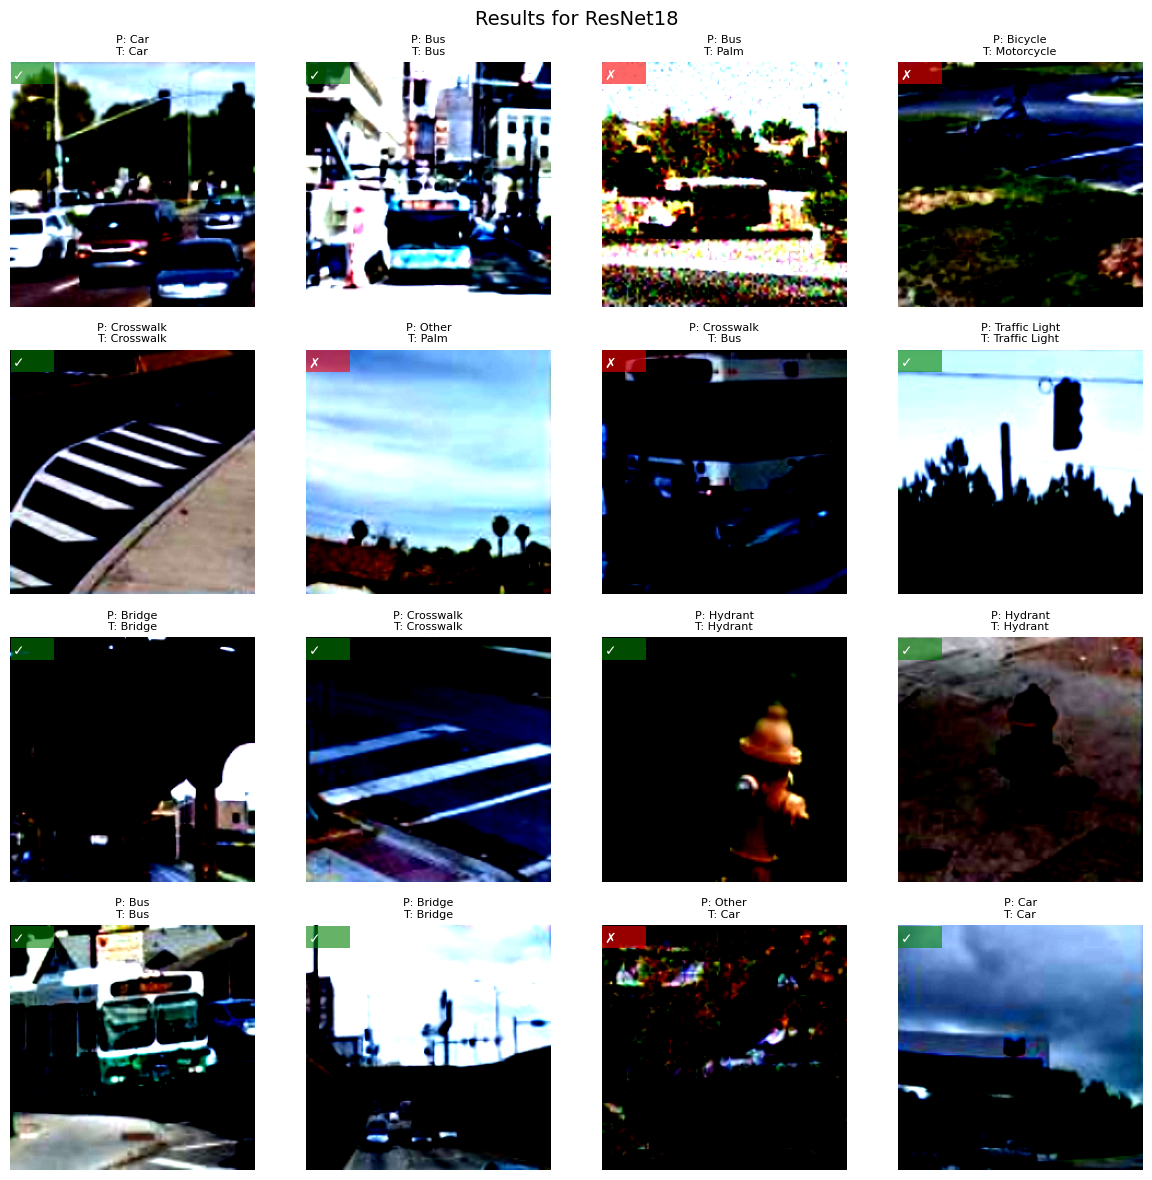

In [140]:
import matplotlib.pyplot as plt
import numpy as np


def plot_model_results(model, dataloader, class_names, model_name, n=16, device='cpu'):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    plt.figure(figsize=(12, 12))
    n_rows = int(np.ceil(np.sqrt(n)))
    for i in range(min(n, len(images))):
        ax = plt.subplot(n_rows, n_rows, i + 1)
        img = np.clip(images[i], 0, 1)
        correct = preds[i] == labels[i]
        color = 'green' if correct else 'red'

        ax.imshow(img)
        ax.add_patch(patches.Rectangle((0, 0), 40, 20, linewidth=0, edgecolor=None, facecolor=color, alpha=0.6))
        ax.text(2, 15, '✓' if correct else '✗', color='white', fontsize=10, weight='bold')
        ax.set_title(f"P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"Results for {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()



plot_model_results(custom_model, test_loader, class_names, "SimpleCNN")
plot_model_results(pretrained_model, test_loader, class_names, "ResNet18")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ea5890d-f23a-494c-a65e-600e775c61ce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>